In [1]:
import pandas as pd
from datetime import datetime

from hft_backtest_engine.data_loader import DataLoader
from hft_backtest_engine.feature_store import FeatureStore
from hft_backtest_engine.strategy_base import Strategy
from hft_backtest_engine.execution import ExecutionEngine
from hft_backtest_engine.backtest_engine import BacktestEngine
from hft_backtest_engine.metrics import compute_metrics, plot_cum_pnl

In [2]:
DATA_ROOT = r"C:\Users\김도훈\OneDrive\바탕 화면\FPA_crypto_project\data"

SYMBOL = "BTCUSDT"
START_DATE = "2025-09-01"
END_DATE   = "2025-09-01"   # 나중에 "2025-10-31" 이렇게만 바꾸면 됨

INITIAL_CAPITAL = 100.0


In [3]:
loader = DataLoader(DATA_ROOT)

feature_store = FeatureStore(
    symbol=SYMBOL,
    signal_interval_seconds=5 * 60,
    vpin_bucket_volume=5e5,   # 디버깅용으로 작게
    vpin_history=100,
    tc_window=60,
    ofi_window_minutes=5,
    ofi_z_window=30,
)

execution = ExecutionEngine(
    latency_ms=20,
    slippage_bp=1.0,
)

strategy = Strategy(
    symbol=SYMBOL,
    feature_store=feature_store,
    initial_capital=INITIAL_CAPITAL,
    signal_interval_seconds=5 * 60,
    max_holding_seconds=240,
    target_bp=10.0,
)

engine = BacktestEngine(
    loader=loader,
    strategy=strategy,
    execution=execution,
    feature_store=feature_store,
    initial_capital=INITIAL_CAPITAL,
)


In [4]:
dates = pd.date_range(
    start=START_DATE,
    end=END_DATE,
    freq="D",
).strftime("%Y-%m-%d").tolist()

print("Backtest dates:", dates)

Backtest dates: ['2025-09-01']


In [5]:
for day in dates:
    print(f"\n===== RUN {SYMBOL} {day} =====")
    try:
        engine.run_day(
            symbol=SYMBOL,
            ymd=day,
        )
    except FileNotFoundError as e:
        print(f"[SKIP] data missing for {day}: {e}")
        continue
    except Exception as e:
        print(f"[ERROR] failed on {day}")
        raise  # 여기서 멈추고 디버깅



===== RUN BTCUSDT 2025-09-01 =====


In [6]:
fills_df = pd.DataFrame(engine.fills)
closed_df = pd.DataFrame(engine.closed_trades)

print("fills:", len(fills_df))
print("closed trades:", len(closed_df))

fills_df.head()

fills: 0
closed trades: 0


""


In [7]:
feature_df = pd.DataFrame(strategy.feature_logs)
feature_df.head()

,ts,vpin_cdf,z_ofi,qr,n_cdf,score
0,2025-09-01 00:00:00.283000+00:00,0.0,0.000000,0.000000,NaN,0.0
1,2025-09-01 00:05:00.385000+00:00,NaN,4.165959,0.301608,NaN,0.0
2,2025-09-01 00:10:00.656000+00:00,NaN,2.458363,0.343902,NaN,0.0
3,2025-09-01 00:15:00.691000+00:00,NaN,7.434530,0.310381,NaN,0.0
4,2025-09-01 00:20:00.751000+00:00,NaN,2.341752,0.345424,NaN,0.0


In [8]:
equity_rows = []

cash = INITIAL_CAPITAL
positions = 0

for _, row in fills_df.iterrows():
    if row["fill_type"] == "ENTER":
        cash -= row["size"]
        positions = 1
    else:
        cash += row["size"] + row.get("pnl", 0.0)
        positions = 0

    equity_rows.append({
        "ts": row["ts"],
        "equity": cash,
        "cash": cash,
        "n_positions": positions,
    })

equity_df = pd.DataFrame(equity_rows)
equity_df.head()

""


In [9]:
metrics = compute_metrics(
    equity_df,
    initial_capital=INITIAL_CAPITAL,
)

for k, v in metrics.items():
    print(f"{k}: {v}")

In [10]:
plot_cum_pnl(
    equity_df,
    initial_capital=INITIAL_CAPITAL,
    title=f"{SYMBOL} VPIN+OFI Strategy ({START_DATE} ~ {END_DATE})",
)

[WARN] equity_curve is empty.


In [2]:
import pandas as pd

from hft_backtest_engine.data_loader import DataLoader
from hft_backtest_engine.execution import ExecutionEngine
from hft_backtest_engine.feature_store import FeatureStore
from hft_backtest_engine.strategy_base import Strategy
from hft_backtest_engine.backtest_engine import BacktestEngine

# =========================
# 설정
# =========================
DATA_ROOT = r"C:\Users\김도훈\OneDrive\바탕 화면\FPA_crypto_project\data"
SYMBOL = "BTCUSDT"
DAY = "2025-09-01"

# =========================
# 엔진 구성
# =========================
loader = DataLoader(DATA_ROOT)

feature_store = FeatureStore(
    symbol=SYMBOL,
    signal_interval_seconds=5 * 60,
)

strategy = Strategy(
    symbol=SYMBOL,
    feature_store=feature_store,
    initial_capital=100.0,
)

execution = ExecutionEngine(
    latency_ms=5,
    slippage_bp=1,
)

engine = BacktestEngine(
    loader=loader,
    strategy=strategy,
    execution=execution,
    feature_store=feature_store,
    initial_capital=100.0,
)

# =========================
# 실행
# =========================
print(f"\n===== RUN {SYMBOL} {DAY} =====")
engine.run_day(symbol=SYMBOL, ymd=DAY)

# =========================
# 결과 확인
# =========================
fills_df = pd.DataFrame(engine.fills)
closed_df = pd.DataFrame(engine.closed_trades)
feature_df = pd.DataFrame(strategy.feature_logs)

print("\n--- RESULT ---")
print("fills:", len(fills_df))
print("closed trades:", len(closed_df))

display(fills_df.head())
display(closed_df.head())
display(feature_df.head())



===== RUN BTCUSDT 2025-09-01 =====

--- RESULT ---
fills: 0
closed trades: 0


""


""


,ts,vpin_cdf,z_ofi,qr,n_cdf,score
0,2025-09-01 00:00:00.283000+00:00,0.0,0.000000,0.000000,NaN,0.0
1,2025-09-01 00:05:00.385000+00:00,NaN,4.165959,0.301608,NaN,0.0
2,2025-09-01 00:10:00.656000+00:00,NaN,2.458363,0.343902,NaN,0.0
3,2025-09-01 00:15:00.691000+00:00,NaN,7.434530,0.310381,NaN,0.0
4,2025-09-01 00:20:00.751000+00:00,NaN,2.341752,0.345424,NaN,0.0


In [1]:
from IPython.display import display

===== RUN DOGEUSDT 2025-09-10 =====
fills: 697
closed trades: 348
                                ts    symbol fill_type  side     price   size  \
0 2025-09-10 00:05:01.046000+00:00  DOGEUSDT     ENTER     1  0.240624  100.0   
1 2025-09-10 00:09:01.117000+00:00  DOGEUSDT      EXIT    -1  0.239706  100.0   
2 2025-09-10 00:09:01.117000+00:00  DOGEUSDT     ENTER    -1  0.239706  100.0   
3 2025-09-10 00:13:01.360000+00:00  DOGEUSDT      EXIT     1  0.239404  100.0   
4 2025-09-10 00:13:01.360000+00:00  DOGEUSDT     ENTER     1  0.239404  100.0   

  order_type  order_id  fee_bp  fee_amt  gross_pnl   net_pnl  entry_fee_amt  
0     market         1     5.0     0.05   0.000000 -0.050000            NaN  
1     market         2     5.0     0.05  -0.381522 -0.481522           0.05  
2     market         3     5.0     0.05   0.000000 -0.050000            NaN  
3     market         4     5.0     0.05   0.126025  0.026025           0.05  
4     market         5     5.0     0.05   0.000000 -0.050

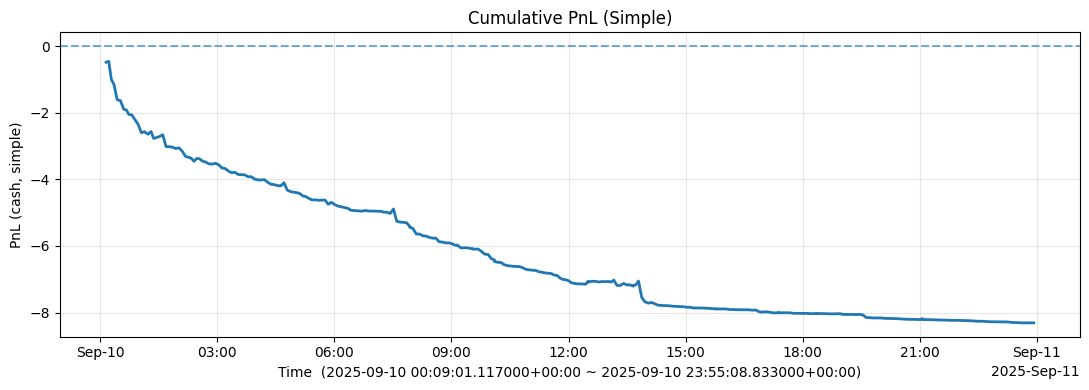

In [1]:
from hft_backtest_engine.data_loader import DataLoader
from hft_backtest_engine.execution import ExecutionEngine
from hft_backtest_engine.feature_store import FeatureStore
from hft_backtest_engine.strategy_base import Strategy
from hft_backtest_engine.backtest_engine import BacktestEngine
from hft_backtest_engine.metrics import compute_metrics, plot_cum_pnl
import pandas as pd

DATA_ROOT = r"C:\Users\김도훈\OneDrive\바탕 화면\FPA_crypto_project\data"
SYMBOL = "DOGEUSDT"
DAY = "2025-09-10"
INITIAL = 100.0

loader = DataLoader(DATA_ROOT)

feature_store = FeatureStore(
    symbol=SYMBOL,
    signal_interval_seconds=5 * 60,
    vpin_bucket_volume=1e6,
)

strategy = Strategy(
    symbol=SYMBOL,
    feature_store=feature_store,
    initial_capital=INITIAL,
    target_bp=60.0,   # ✅ 올린 값
)

execution = ExecutionEngine(
    latency_ms=5,
    slippage_bp=1.0,
    fee_bp_market=5.0,
    fee_bp_limit=2.0,
)

engine = BacktestEngine(
    loader=loader,
    strategy=strategy,
    execution=execution,
    feature_store=feature_store,
    initial_capital=INITIAL,
    verbose=False,
)

print(f"===== RUN {SYMBOL} {DAY} =====")
engine.run_day(SYMBOL, DAY)

fills_df = pd.DataFrame(engine.fills)
closed_df = pd.DataFrame(engine.closed_trades)

print("fills:", len(fills_df))
print("closed trades:", len(closed_df))
print(fills_df.head())
print(closed_df.head())

# equity curve: net_pnl 기준으로 만들기
if not closed_df.empty:
    equity_curve = (
        closed_df
        .assign(net_pnl=lambda x: pd.to_numeric(x["net_pnl"], errors="coerce").fillna(0.0))
        .assign(equity=lambda x: INITIAL + x["net_pnl"].cumsum())
        .assign(cash=lambda x: INITIAL + x["net_pnl"].cumsum())
        .assign(n_positions=0)
        [["exit_ts", "equity", "cash", "n_positions"]]
        .rename(columns={"exit_ts": "ts"})
    )

    metrics = compute_metrics(equity_curve, fills=fills_df, initial_capital=INITIAL)
    print(metrics)
    plot_cum_pnl(equity_curve, initial_capital=INITIAL)
else:
    print("⚠️ No trades executed.")


In [7]:
# run_backtest_multi_day.py

from datetime import datetime, timedelta
import pandas as pd

START = "2025-09-01"
END   = "2025-09-30"

start_dt = datetime.strptime(START, "%Y-%m-%d")
end_dt   = datetime.strptime(END, "%Y-%m-%d")

all_closed = []

dt = start_dt
while dt <= end_dt:
    day = dt.strftime("%Y-%m-%d")
    print(f"\n===== RUN {SYMBOL} {day} =====")

    try:
        engine.run_day(SYMBOL, day)
        if engine.closed_trades:
            all_closed.extend(engine.closed_trades)
            engine.closed_trades.clear()
            engine.fills.clear()
    except FileNotFoundError as e:
        print(f"[SKIP] {day} missing data")

    dt += timedelta(days=1)


===== RUN BTCUSDT 2025-09-01 =====

===== RUN BTCUSDT 2025-09-02 =====

===== RUN BTCUSDT 2025-09-03 =====

===== RUN BTCUSDT 2025-09-04 =====

===== RUN BTCUSDT 2025-09-05 =====

===== RUN BTCUSDT 2025-09-06 =====

===== RUN BTCUSDT 2025-09-07 =====

===== RUN BTCUSDT 2025-09-08 =====

===== RUN BTCUSDT 2025-09-09 =====

===== RUN BTCUSDT 2025-09-10 =====

===== RUN BTCUSDT 2025-09-11 =====

===== RUN BTCUSDT 2025-09-12 =====

===== RUN BTCUSDT 2025-09-13 =====

===== RUN BTCUSDT 2025-09-14 =====

===== RUN BTCUSDT 2025-09-15 =====

===== RUN BTCUSDT 2025-09-16 =====

===== RUN BTCUSDT 2025-09-17 =====

===== RUN BTCUSDT 2025-09-18 =====

===== RUN BTCUSDT 2025-09-19 =====

===== RUN BTCUSDT 2025-09-20 =====

===== RUN BTCUSDT 2025-09-21 =====

===== RUN BTCUSDT 2025-09-22 =====

===== RUN BTCUSDT 2025-09-23 =====

===== RUN BTCUSDT 2025-09-24 =====

===== RUN BTCUSDT 2025-09-25 =====

===== RUN BTCUSDT 2025-09-26 =====

===== RUN BTCUSDT 2025-09-27 =====

===== RUN BTCUSDT 2025-09-2


=== METRICS (MULTI-DAY, NET) ===
Final Equity: 11.954537005213538
Total PnL (equity): -88.04546299478646
Total Return (%): -88.04546299478646
Sharpe: -115.88243832731229
MDD (%): -87.85696810130173
RMDD: -1.0021454745998906
Mean Ret: -0.010012190097014442
Std Ret: 0.05204667363018257


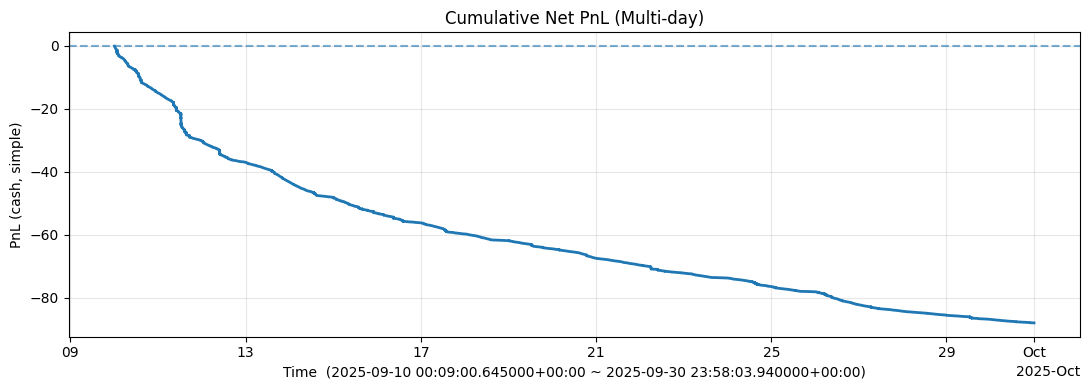

In [8]:
INITIAL_CAPITAL = 100.0  # ← 네가 사용한 초기자본으로 맞춰줘

if all_closed:
    closed_df = pd.DataFrame(all_closed).sort_values("exit_ts")

    # ✅ net_pnl 기준 누적
    equity_curve = (
        closed_df
        .assign(
            equity=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            cash=lambda x: INITIAL_CAPITAL + x["net_pnl"].cumsum(),
            n_positions=0,
        )
        [["exit_ts", "equity", "cash", "n_positions"]]
        .rename(columns={"exit_ts": "ts"})
    )

    metrics = compute_metrics(
        equity_curve,
        fills=None,                 # fills 없어도 OK
        initial_capital=INITIAL_CAPITAL,
    )

    print("\n=== METRICS (MULTI-DAY, NET) ===")
    for k, v in metrics.items():
        print(f"{k}: {v}")

    plot_cum_pnl(
        equity_curve,
        initial_capital=INITIAL_CAPITAL,
        title="Cumulative Net PnL (Multi-day)",
    )
else:
    print("⚠️ No trades in entire period.")